# Úkol č. 4

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image  
import pydotplus
from pydotplus import graph_from_dot_data

## Rozhodovací strom

Náhled dat:

In [110]:
data = pd.read_csv(fr"_data\ukol_04_data.csv")

data

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49727,33,services,married,secondary,no,-333,yes,no,cellular,30,jul,329,5,-1,0,unknown,no
49728,57,self-employed,married,tertiary,yes,-3313,yes,yes,unknown,9,may,153,1,-1,0,unknown,no
49729,57,technician,married,secondary,no,295,no,no,cellular,19,aug,151,11,-1,0,unknown,no
49730,28,blue-collar,married,secondary,no,1137,no,no,cellular,6,feb,129,4,211,3,other,no


Vylistování názvů sloupců (ať se neupíšeme):

In [111]:
list(data.columns)

['age',
 'job',
 'marital',
 'education',
 'default',
 'balance',
 'housing',
 'loan',
 'contact',
 'day',
 'month',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'poutcome',
 'y']

Rozdělení vstupních proměnných na kategoriální a číselné:

In [112]:
categorical_columns = [
                    'job',
                    'marital',
                    'education',
                    'default',
                    'housing',
                    'loan',
                    'contact',
                    'poutcome'
                        ]

numerical_columns = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']

y = data["y"]

Konverze kategorických proměnných na číselné:

In [113]:
encoder = OneHotEncoder()
encoded_columns = encoder.fit_transform(data[categorical_columns])


In [114]:
encoder.get_feature_names_out()

array(['job_admin.', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student',
       'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'education_primary', 'education_secondary', 'education_tertiary',
       'education_unknown', 'default_no', 'default_yes', 'housing_no',
       'housing_yes', 'loan_no', 'loan_yes', 'contact_cellular',
       'contact_telephone', 'contact_unknown', 'poutcome_failure',
       'poutcome_other', 'poutcome_success', 'poutcome_unknown'],
      dtype=object)

Zobrazení transformovaných kategorických dat v podobě tabulky:

In [115]:
pd.DataFrame(encoded_columns.toarray(), columns=encoder.get_feature_names_out()).head()

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,housing_yes,loan_no,loan_yes,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


Spojení obou typů dat do jedné matice:

In [116]:
# proč se funkce "toarray" znázorňuje bíle? :-) 
# Jirka u ní v materiálech zřejmě omylem odkazuje na pandas, ale patří pod scipy 
# (sparse -> dense array) - tady zřejmě pod sklearn (encoder)?
encoded_columns = encoded_columns.toarray()

others = data[numerical_columns].to_numpy()

X = np.concatenate([encoded_columns, others], axis= 1)

Rozdělení dat, trénink a vyhodnocení (maximální hloubka stromu omezená na 4 úrovně):

In [117]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify = y)

# omezení výšky stromu na 4 patra 
clf = DecisionTreeClassifier(max_depth= 4)
clf = clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

Grafický výstup:

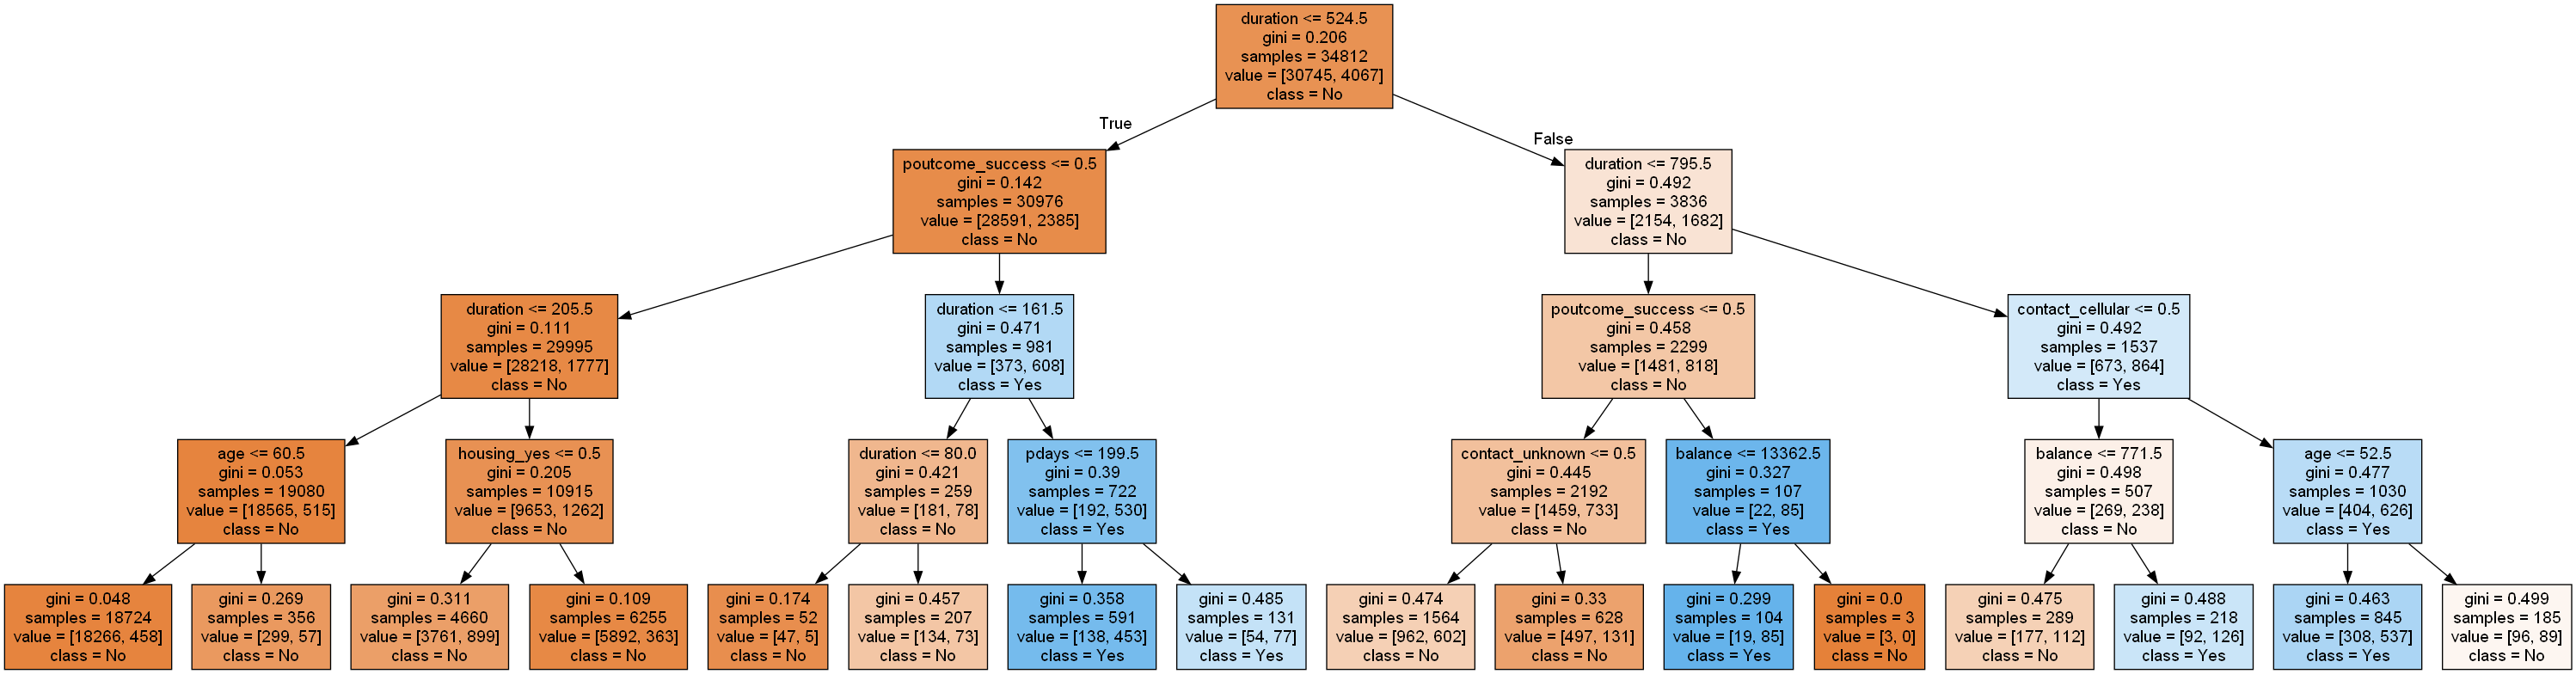

In [118]:
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data, filled=True, feature_names=list(encoder.get_feature_names_out()) + numerical_columns, class_names=["No", "Yes"])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

Matice záměn:

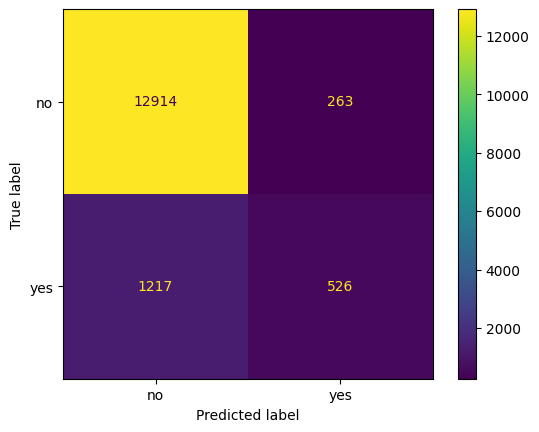

In [119]:
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)

Metrika accuracy:

In [120]:
accuracy_score(y_test, y_pred)

0.900804289544236

## Výběr vhodné metriky pro porovnání algoritmů

Marketingové oddělení banky zajímá metrika "precision", která říká, jaký poměr predikovaných zájemců o termínovaný účet o něj opravdu bude stát (tj. aby true positives byly co nejméně ovlivněny false positives, zatímco false negatives tolik nevadí).

In [121]:
precision_score(y_test, y_pred, pos_label = "yes")

0.6666666666666666

## K-Nearest Neighbours

Standardizace hodnot číselných proměnných (směrodatnou odchylkou):

In [122]:
scaler = StandardScaler()
numeric_data = scaler.fit_transform(data[numerical_columns])

X = np.concatenate([encoded_columns, numeric_data], axis=1)

Rozdělení dat, trénink a vyhodnocení modelu:

In [123]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = KNeighborsClassifier()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

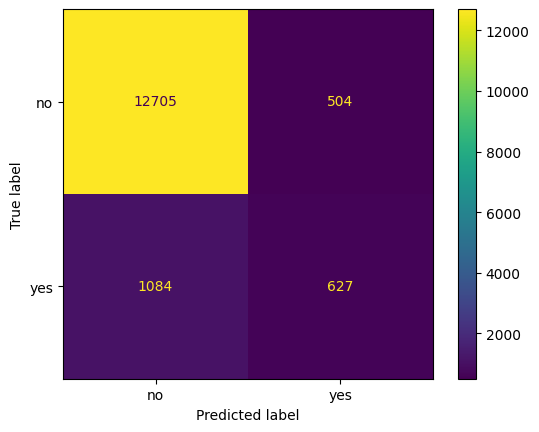

In [124]:
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)

Úprava parametrů:

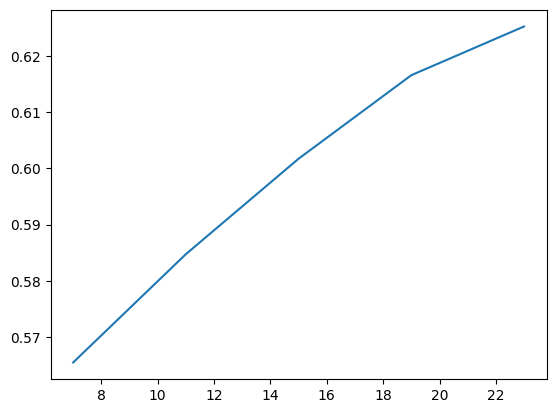

In [125]:
# starý dobrý cyklus :)

ks = range(7, 24, 4)
precision_scores = []

for k in ks:
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    precision_scores.append(precision_score(y_test, y_pred, pos_label= "yes"))

plt.plot(ks, precision_scores)

In [126]:
precision_scores

[0.565425023877746,
 0.5847280334728033,
 0.6017410228509249,
 0.6166281755196305,
 0.6253071253071253]

Při úpravě hodnot počtu "sousedů" se hodnota metriky precision postupně navyšuje. V případě maximálního předvybraného počtu (23) vykázala hodnotu 0.625. Hodnotu metriky precision v případě rozhodovacího stromu tak nepřekračuje.

## Support Vector Machine

Úprava a rozdělení dat zůstává z předchozího modelu.

In [127]:
clf = LinearSVC()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

C:\Users\ivato\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


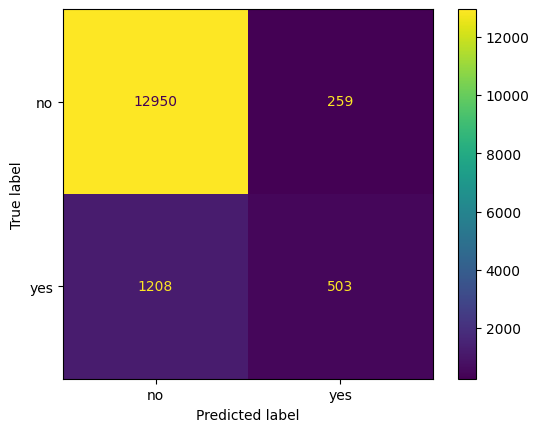

In [128]:
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)

In [129]:
precision_score(y_test, y_pred, pos_label = "yes")

0.6601049868766404

## Návrat k testovacímu stromu na závěr

Při porovnání hodnot metriky precision u všech tří využitých algoritmů vychází nejlépe rozhodovací strom. Rozdíly však nejsou velké, úprava některých metrik by mohla pomoci získat ještě lepší výsledek.

Můžeme vyzkoušet, zda není možné zlepšit hodnotu metriky také u algoritmu rozhodovacího stromu, při úpravě maximální hloubky:

In [130]:
X = np.concatenate([encoded_columns, others], axis= 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

max_depth = range(2, 13)
precision_scores = []

for d in max_depth:
    clf = DecisionTreeClassifier(max_depth= d)
    clf = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    precision_scores.append(precision_score(y_test, y_pred, pos_label= "yes"))
    print(f"max depth {d}: {precision_scores[-1]}")

max depth 2: 0.6047169811320755
max depth 3: 0.6816380449141347
max depth 4: 0.6666666666666666
max depth 5: 0.6678445229681979
max depth 6: 0.6102325581395349
max depth 7: 0.6241799437675727
max depth 8: 0.6258776328986961
max depth 9: 0.6126629422718808
max depth 10: 0.6131117266851339
max depth 11: 0.5974614687216682
max depth 12: 0.60431654676259


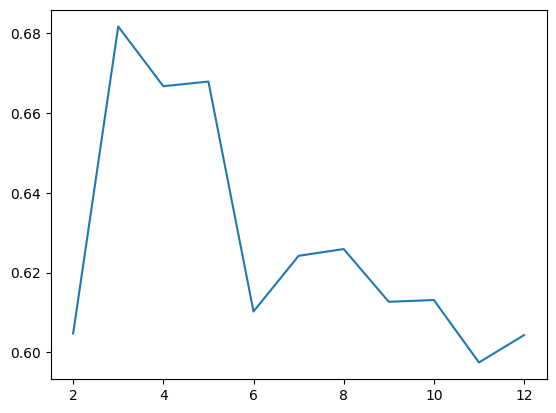

In [131]:
plt.plot(max_depth, precision_scores)

Zdá se, že čím míň pater stromu, tím pro hodnotu metriky precision lépe. Pro jistotou ještě accuracy u zatím nejnižší dosažené hodnoty platné pro max hloubku stromu 3:

In [132]:
accuracy_score(y_test, y_pred)

0.8987265415549598

Accuracy poklesla z hodnoty 0,901 na 0,899. To není velký skok. Algoritmus rozhodovacího stromu s omezením maximální hloubky na tři úrovně vypadá jako adept na vítěze :)